# Project1 - Group 4


### Library dependencies

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
import datetime as dt

#import statsmodels.api as sm

# import requests
# import time
# from scipy.stats import linregress
# import datetime

from scipy import stats


from os import listdir
from os.path import isfile, join
# Reference: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

import warnings
warnings.filterwarnings('ignore')

# Data sources - load, consolidate, and merge

In [2]:
# Paths to analysis data files:
# Uber trips files from Kaggle
uber2014_path = join("data", "kaggle_csv", "uber-raw-data-2014")
# New York city Weather for months corresponding to the Uber trips
noaa2014_path = "data/noaa_csv/2014"

### Consolidate Uber trips data

In [3]:
# Read the Uber trips data and consolidate into one file
# Uber trips files from Kaggle
uber2014 = pd.DataFrame()
files = [join(uber2014_path, f) for f in listdir(uber2014_path) if isfile(join(uber2014_path, f))]
for f in files:
    data = pd.read_csv(f)
    if (len(uber2014)) == 0:    
        uber2014 = data.copy(deep=True)
    else:
        combined = pd.concat([uber2014, data], axis=0, ignore_index=True)
        uber2014 = combined.copy(deep=True)

In [4]:
# Check for and remove duplicate rows
uber2014 = uber2014.drop_duplicates()

In [5]:
# Convert from US-format date, and split orginal datetime into Date and Time columns
uber2014["DateTime"] = pd.to_datetime(uber2014["Date/Time"], format='%m/%d/%Y %H:%M:%S')
uber2014["Date"] = uber2014["DateTime"].dt.normalize()
uber2014 = uber2014[["Date", "DateTime", "Lat", "Lon", "Base"]]

In [6]:
# Write out the combined dataset
uber2014.to_csv(join("data", "combined", "uber-combined-data-2014.csv"), encoding = "UTF-8", index=False)
print(f"Total unique rows (Uber rides 2014 data): {len(uber2014):,}")

Total unique rows (Uber rides 2014 data): 4,451,746


### Consolidate New York City weather data for the trips period (& convert to metric units)

In [7]:
# Formulas for conversion of temperature and rainfall to metric units
def Convert_Fahrenheit_to_Celsius(deg_F):
    deg_C = (deg_F - 32) / (9/5)
    return deg_C

def Inches_to_Millimetres(inches):
    millimetres = inches * 25.4
    return millimetres

In [8]:
# Read the Weather data, convert to metric units, and consolidate into one file
# Uber trips files from NOAA
weather2014 = pd.DataFrame()
files = [join(noaa2014_path, f) for f in listdir(noaa2014_path) if isfile(join(noaa2014_path, f))]
for f in files:
    data = pd.read_csv(f)
    if (len(weather2014)) == 0:    
        weather2014 = data.copy(deep=True)
    else:
        combined = pd.concat([weather2014, data], axis=0, ignore_index=True)
        weather2014 = combined.copy(deep=True)
        
# Fix column names to remove newlines introduced by 'word wrap' in CSV file header
weather2014.columns = ["Year", "Month", "Day", "MaxTemp_(degF)", "MinTemp_(degF)", "Rain_MeltedSnow_Etc_(in)", "Snow_IcePellets_Hail_(in)", "Snow_IcePellets_Hail_IceOnGround_(in)"]

# We want to keep the 24-hour observation values only, so drop the "Snow_IcePellets_Hail_IceOnGround_(in)" column as that represented 'at observation time' data.
weather2014 = weather2014[["Year", "Month", "Day", "MaxTemp_(degF)", "MinTemp_(degF)", "Rain_MeltedSnow_Etc_(in)", "Snow_IcePellets_Hail_(in)"]]

# Combine Year-Month-Day columns for form a date value in yyyy-mm-dd format
weather2014["Date"] = pd.to_datetime(dict(year=weather2014.Year, month=weather2014.Month, day=weather2014.Day))

# Convert temperature and rainfall to metric units
weather2014["MaxTemp_degC"] = weather2014["MaxTemp_(degF)"].apply(Convert_Fahrenheit_to_Celsius).round(3)
weather2014["MinTemp_degC"] = weather2014["MinTemp_(degF)"].apply(Convert_Fahrenheit_to_Celsius).round(3)
weather2014["Rain_MeltedSnow_Etc_mm"] = weather2014["Rain_MeltedSnow_Etc_(in)"].apply(Inches_to_Millimetres).round(3)
weather2014["Snow_IcePellets_Hail_mm"] = weather2014["Snow_IcePellets_Hail_(in)"].apply(Inches_to_Millimetres).round(3)

# Combine Rain & Snow readings into single 'Precipitation' value
weather2014["Precipitation_mm"] = weather2014["Rain_MeltedSnow_Etc_mm"] + weather2014["Snow_IcePellets_Hail_mm"]

# Keep just the metric values
weather2014 = weather2014[["Date", "MaxTemp_degC", "MinTemp_degC", "Precipitation_mm"]]

# Write out combined data with metric units
weather2014.to_csv(join("data", "combined", "weather-combined-data-metric-2014.csv"), encoding = "UTF-8", index=False)


## Merge Uber trips and Weather data

In [9]:
# Merge the Uber data with the Weather data on the Date column
Uber_Weather_df = pd.merge(uber2014, weather2014, on="Date", how='left')

# Display the first few rows of the merged DataFrame
Uber_Weather_df.head()

,Date,DateTime,Lat,Lon,Base,MaxTemp_degC,MinTemp_degC,Precipitation_mm
0,2014-04-01,2014-04-01 00:11:00,40.7690,-73.9549,B02512,15.556,3.889,0.0
1,2014-04-01,2014-04-01 00:17:00,40.7267,-74.0345,B02512,15.556,3.889,0.0
2,2014-04-01,2014-04-01 00:21:00,40.7316,-73.9873,B02512,15.556,3.889,0.0
3,2014-04-01,2014-04-01 00:28:00,40.7588,-73.9776,B02512,15.556,3.889,0.0
4,2014-04-01,2014-04-01 00:33:00,40.7594,-73.9722,B02512,15.556,3.889,0.0


In [10]:
# Cross check the number of rows
num_rows = len(Uber_Weather_df)
print(f"Number of rows in Uber_Weather_merged_data: {num_rows:,}")

Number of rows in Uber_Weather_merged_data: 4,451,746


# Exploratory Data Analysis

In [11]:
# Add calculation of mean daily temperature
Uber_Weather_df["MeanTemp_degC"] = Uber_Weather_df["MaxTemp_degC"] - ((Uber_Weather_df["MaxTemp_degC"] - Uber_Weather_df["MinTemp_degC"])/2)

# Assign categorical flag to the dataset, to define three groups: cold (0), mild (1), and warm (2) temperatures
Uber_Weather_df["TempBand"] = Uber_Weather_df["MeanTemp_degC"].apply(lambda t: "cold" if t < 10 else ("mild" if (t >= 10 and t <= 25) else "warm") )

# Assign categorical flag to the dataset, to define whether there was Preciptiation (rain/melted snow, or snow/ice) in the 24-hour observation period
Uber_Weather_df["Precipitation_YN"] = Uber_Weather_df["Precipitation_mm"].apply(lambda p: "Y" if p > 0.0 else "N")

Uber_Weather_df.head()

,Date,DateTime,Lat,Lon,Base,MaxTemp_degC,MinTemp_degC,Precipitation_mm,MeanTemp_degC,TempBand,Precipitation_YN
0,2014-04-01,2014-04-01 00:11:00,40.7690,-73.9549,B02512,15.556,3.889,0.0,9.7225,cold,N
1,2014-04-01,2014-04-01 00:17:00,40.7267,-74.0345,B02512,15.556,3.889,0.0,9.7225,cold,N
2,2014-04-01,2014-04-01 00:21:00,40.7316,-73.9873,B02512,15.556,3.889,0.0,9.7225,cold,N
3,2014-04-01,2014-04-01 00:28:00,40.7588,-73.9776,B02512,15.556,3.889,0.0,9.7225,cold,N
4,2014-04-01,2014-04-01 00:33:00,40.7594,-73.9722,B02512,15.556,3.889,0.0,9.7225,cold,N


In [12]:
max_temperature_summary_df = Uber_Weather_df.agg({'MaxTemp_degC': ['max', 'mean', 'median', 'min']})
avg_temperature_summary_df = Uber_Weather_df.agg({'MeanTemp_degC': ['max', 'mean', 'median', 'min']})
min_temperature_summary_df = Uber_Weather_df.agg({'MinTemp_degC': ['max', 'mean', 'median', 'min']})
precipitation_summary_df = Uber_Weather_df.agg({'Precipitation_mm': ['max', 'mean', 'median', 'min']})
weather_summary_df = pd.concat([max_temperature_summary_df, avg_temperature_summary_df, min_temperature_summary_df, precipitation_summary_df], axis=1)
weather_summary_df

,MaxTemp_degC,MeanTemp_degC,MinTemp_degC,Precipitation_mm
max,33.333000,29.166500,25.000000,126.23800
mean,24.879911,20.530011,16.180111,4.10819
median,26.111000,21.667000,17.222000,0.00000
min,8.333000,4.444000,-0.556000,0.00000


In [13]:
trips_df = Uber_Weather_df.groupby(["Date", "TempBand", "MeanTemp_degC", "Precipitation_YN", "Precipitation_mm"]).size().reset_index(name="Trips")

trips_df.head()


#trips = trips_grp.reset_index()

#trips.head()

#mild_trips = trips_grp[ Uber_Weather_df["TempBand"] == "mild" ]

#mild_trips.head()

,Date,TempBand,MeanTemp_degC,Precipitation_YN,Precipitation_mm,Trips
0,2014-04-01,cold,9.7225,N,0.000,14376
1,2014-04-02,cold,8.8890,N,0.000,17230
2,2014-04-03,mild,13.6110,Y,1.778,20482
3,2014-04-04,cold,6.3885,Y,5.334,26353
4,2014-04-05,cold,8.3330,N,0.000,19273


### Tests for normal distribution
Reference: https://michael-fuchs-python.netlify.app/2019/09/13/check-for-normal-distribution/

In [14]:
stats.normaltest(trips_df["Trips"])


NormaltestResult(statistic=2.2761227576058136, pvalue=0.32043963112003904)

In [15]:
trips_statistics_df = trips_df.agg({'Trips': ['max', 'mean', 'median', 'min', 'var', 'std', 'sem']})
trips_statistics_df

,Trips
max,4.216900e+04
mean,2.432648e+04
median,2.404500e+04
min,1.003100e+04
var,4.712829e+07
std,6.865005e+03
sem,5.074758e+02


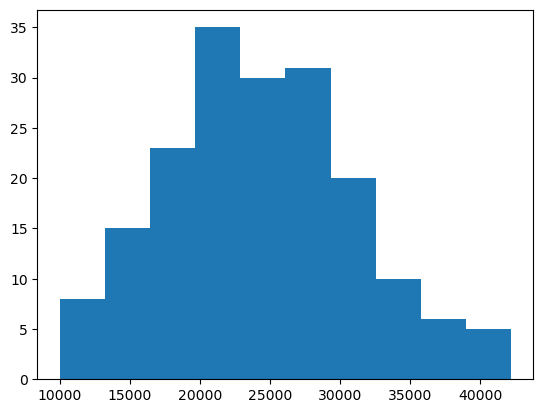

In [16]:
plt.hist(trips_df["Trips"])
plt.show()

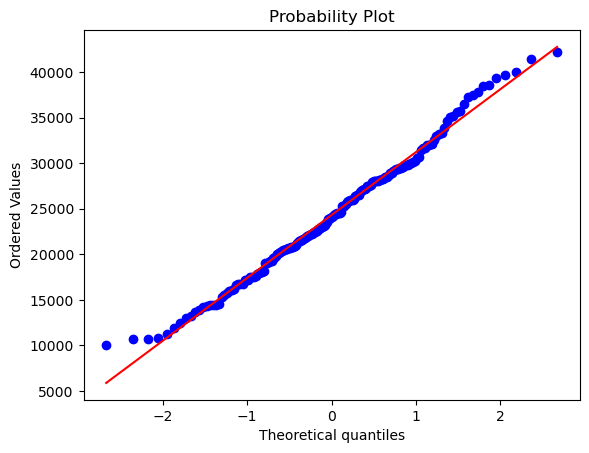

In [17]:
stats.probplot(trips_df["Trips"], dist="norm", plot=pylab)
pylab.show()

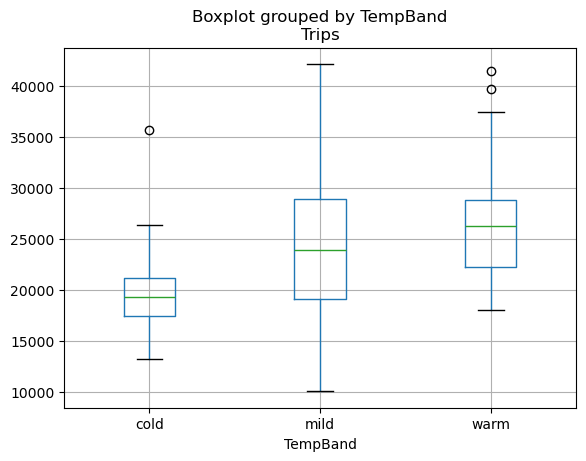

In [18]:
ax = trips_df.boxplot("Trips", by="TempBand", positions=[0, 1, 2])

### Linear regression

In [19]:
# Define a function to create Linear Regression plots
#
# Reference: adjustments for the case where 'x_axis_variable' specifies Dates use the approach in the following article:
# https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis
#
def create_scatterplot_with_linear_regression_overlay(df, x_axis_variable, line_eq_location_xy_tuple):
    # Subset the supplied dataframe according to Latitude & the requested 'x_axis_variable'
    y_axis_variable = "Trips"
    dataset = df[ [x_axis_variable, y_axis_variable] ]
    
    # Compute linear regression calculations...
    if x_axis_variable == "Date":
        dataset["DateOrdinal"] = pd.to_datetime(dataset["Date"]).apply(lambda date: date.toordinal())
        x_axis_variable = "DateOrdinal"
    else:
        x_values = dataset[x_axis_variable]
    x_values = dataset[x_axis_variable]
    y_values = dataset[y_axis_variable]
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # ...and output the correlation coefficient
    print(f"The r^2-value is:  {rvalue**2}")
    
    # Create the scatter plot
    x_axis_label = "Date" if x_axis_variable == "DateOrdinal" else x_axis_variable
    y_axis_label = "Daily Trips"
    ax = dataset.plot(kind='scatter', x=x_axis_variable, y=y_axis_variable, legend=False, \
                 xlabel=x_axis_label, ylabel=y_axis_label, \
                 title = f"{y_axis_label} vs {x_axis_label}"
                )
    
    # Adjust x-axis labels to show Dates (rather than DateOrdinals) if x_axis_variable specifies Dates
    if x_axis_variable == "DateOrdinal":
        ax.set_xlabel('Date')
        new_labels = [dt.date.fromordinal(int(item)) for item in ax.get_xticks()]
        ax.set_xticklabels(new_labels, rotation=45)
        
    # Overlay the regression line
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq, line_eq_location_xy_tuple, fontsize=14, color='red')
    plt.show()

The r^2-value is:  0.02905933825732462


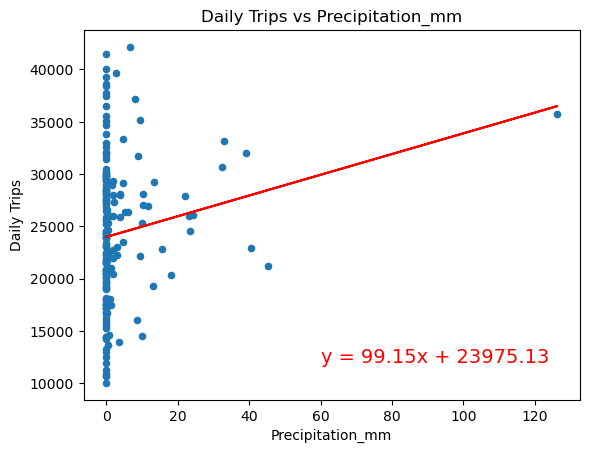

In [20]:
create_scatterplot_with_linear_regression_overlay(trips_df, "Precipitation_mm", (60, 12000))

The r^2-value is:  0.06842327287620183


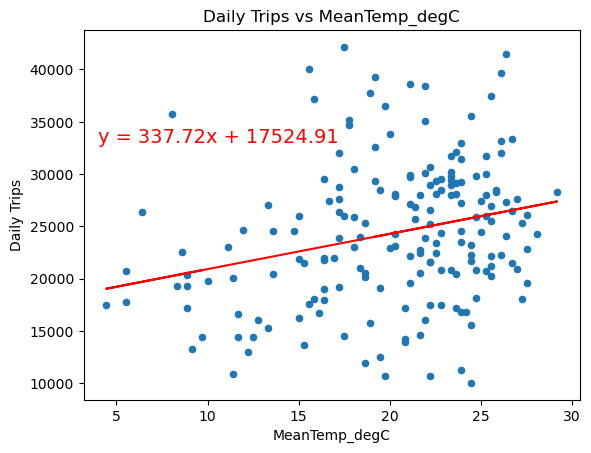

In [21]:
create_scatterplot_with_linear_regression_overlay(trips_df, "MeanTemp_degC", (4, 33000))

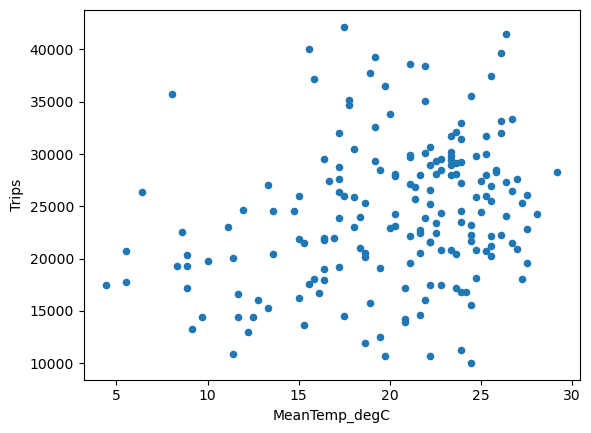

In [22]:
trips_df.plot(kind='scatter', x="MeanTemp_degC", y="Trips", legend=False)
plt.show()

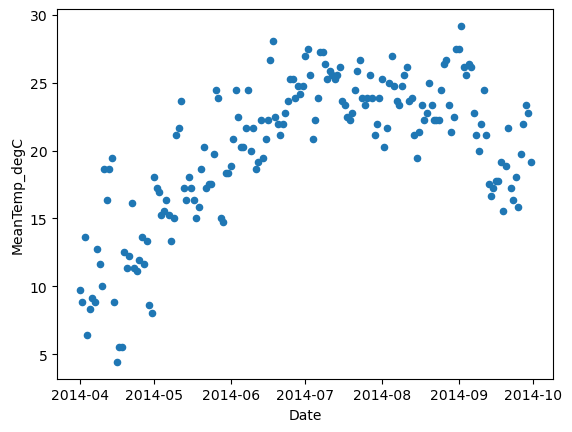

In [23]:
trips_df.plot(kind='scatter', x="Date", y="MeanTemp_degC", legend=False)
plt.show()

The r^2-value is:  0.4525404301061459


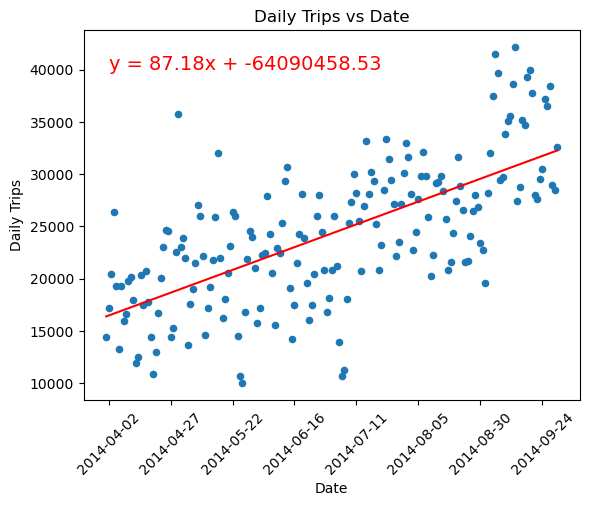

In [24]:
create_scatterplot_with_linear_regression_overlay(trips_df, "Date", (735325, 40000))

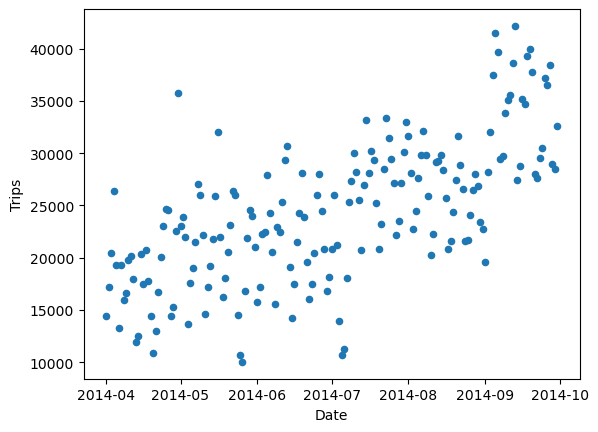

In [25]:
trips_df.plot(kind='scatter', x="Date", y="Trips", legend=False)
plt.show()

In [26]:
Uber_Weather_temp_grp = Uber_Weather_df.groupby("TempBand")
trip_counts_by_temperature_band_df = pd.DataFrame(Uber_Weather_temp_grp["MeanTemp_degC"].count())
trip_counts_by_temperature_band_df.columns = ["Trips"]
trip_counts_by_temperature_band_df

,Trips
TempBand,
cold,244385
mild,3346778
warm,860583


In [27]:
Uber_Weather_rain_grp = Uber_Weather_df.groupby("Precipitation_YN")
trip_counts_by_precipitation_flag_df = pd.DataFrame(Uber_Weather_rain_grp["Precipitation_mm"].count())
trip_counts_by_precipitation_flag_df.columns = ["Trips"]
trip_counts_by_precipitation_flag_df

,Trips
Precipitation_YN,
N,2936848
Y,1514898


# Statistical Analysis

### REVISIT: describe Null & Alternative Hypothesis (1)

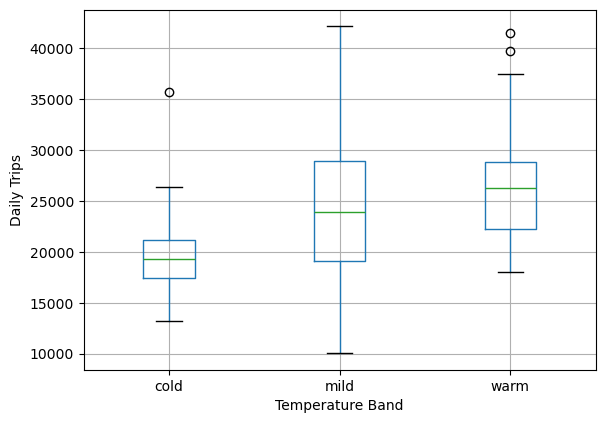

In [28]:
# Create a boxplot to compare means
ax = trips_df.boxplot(column="Trips", by="TempBand", grid=True, positions=[0, 1, 2])
ax.set_ylabel("Daily Trips")
ax.set_xlabel("Temperature Band")
plt.title("")
plt.suptitle("")
plt.show()
# Reference re: clearing boxplot title/suptitle:
# https://stackoverflow.com/questions/23507229/set-no-title-for-pandas-boxplot-groupby

In [29]:
# Extract data for each temperature band
cold_trips = trips_df[ trips_df["TempBand"] == "cold"]["Trips"]
mild_trips = trips_df[ trips_df["TempBand"] == "mild"]["Trips"]
warm_trips = trips_df[ trips_df["TempBand"] == "warm"]["Trips"]


In [30]:
# Perform ANOVA
stats.f_oneway(cold_trips, mild_trips, warm_trips)

F_onewayResult(statistic=4.491553926012563, pvalue=0.01248695804470452)

### Normality test - cold

In [31]:
stats.normaltest(cold_trips)

NormaltestResult(statistic=10.815135757599574, pvalue=0.004482529018387834)

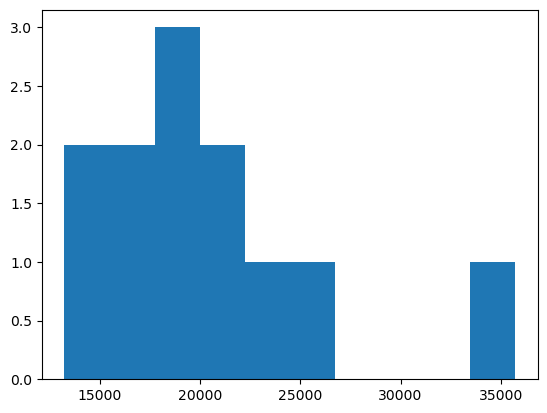

In [32]:
plt.hist(cold_trips)
plt.show()

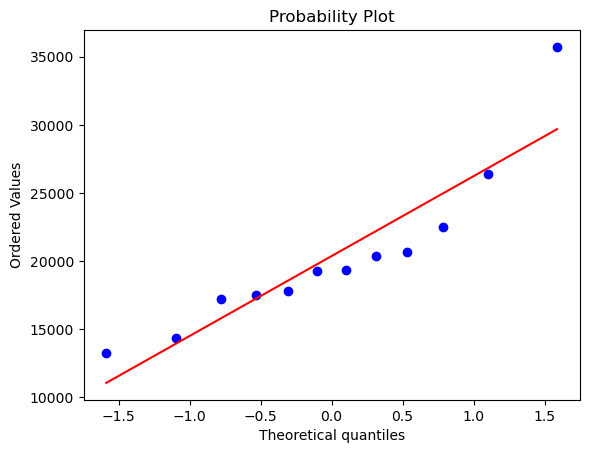

In [33]:
stats.probplot(cold_trips, dist="norm", plot=pylab)
pylab.show()

### Normality test - mild

In [34]:
stats.normaltest(mild_trips)

NormaltestResult(statistic=1.5929067652315057, pvalue=0.4509253913174487)

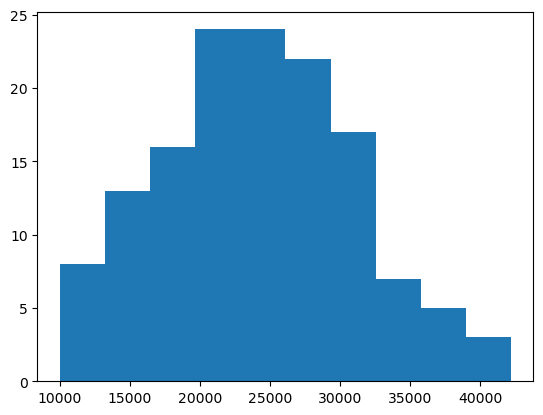

In [35]:
plt.hist(mild_trips)
plt.show()

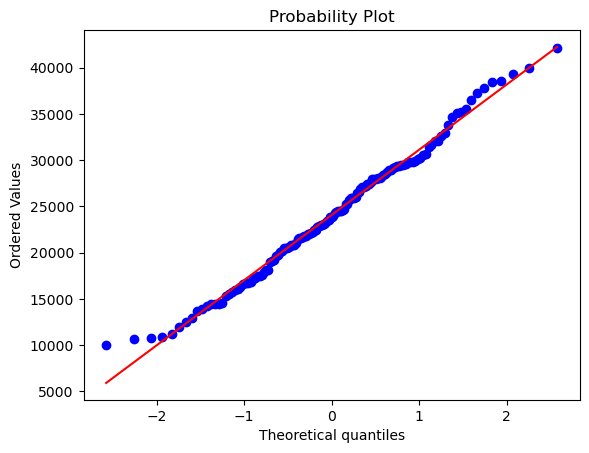

In [36]:
stats.probplot(mild_trips, dist="norm", plot=pylab)
pylab.show()

### Normality test - warm

In [37]:
stats.normaltest(warm_trips)

NormaltestResult(statistic=4.539569709228501, pvalue=0.10333440961314147)

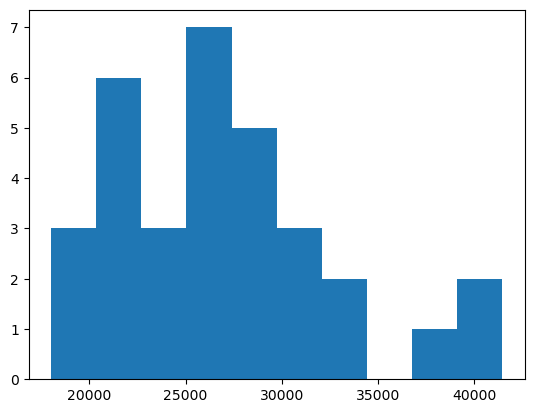

In [38]:
plt.hist(warm_trips)
plt.show()

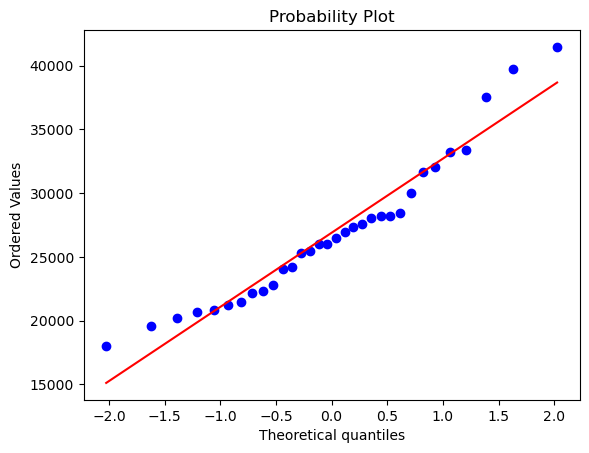

In [39]:
stats.probplot(warm_trips, dist="norm", plot=pylab)
pylab.show()

### REVISIT: describe Null & Alternative Hypothesis (2)

<Axes: title={'center': 'Trips'}, xlabel='Precipitation_YN'>

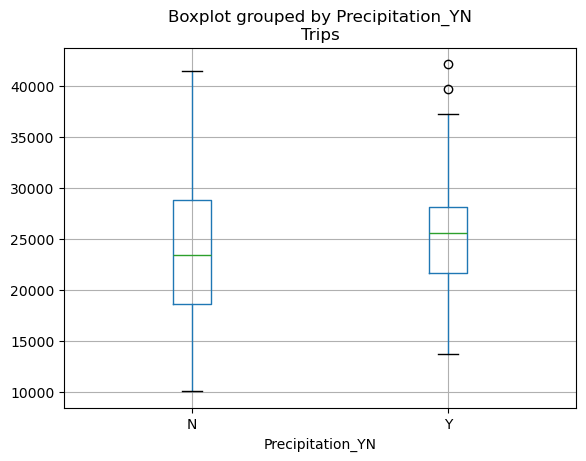

In [40]:
trips_df.boxplot("Trips", by="Precipitation_YN")

In [41]:
# Extract data for each precipitation flag
rain_trips = trips_df[ trips_df["Precipitation_YN"] == "Y"]["Trips"]
dry_trips = trips_df[ trips_df["Precipitation_YN"] == "N"]["Trips"]

In [42]:
stats.ttest_ind(dry_trips, rain_trips, equal_var=False)

TtestResult(statistic=-1.341980933263342, pvalue=0.1818518169042886, df=135.18436440573197)

### Tests for normal distribution

In [43]:
stats.normaltest(rain_trips)

NormaltestResult(statistic=2.3482475491446335, pvalue=0.30908969331633546)

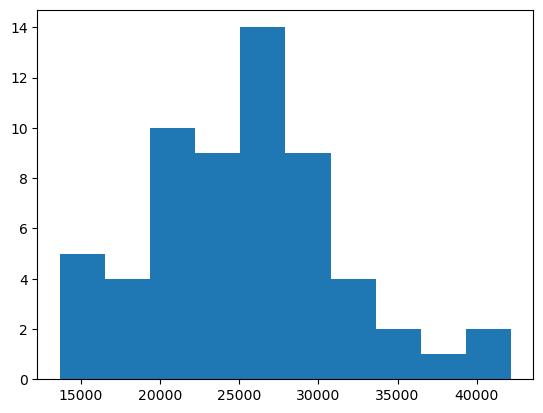

In [44]:
plt.hist(rain_trips)
plt.show()

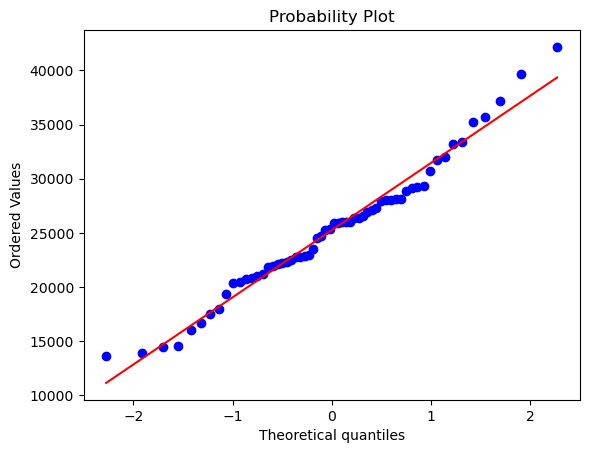

In [45]:
stats.probplot(rain_trips, dist="norm", plot=pylab)
pylab.show()

In [46]:
stats.normaltest(dry_trips)

NormaltestResult(statistic=2.698832155253454, pvalue=0.2593916810387109)

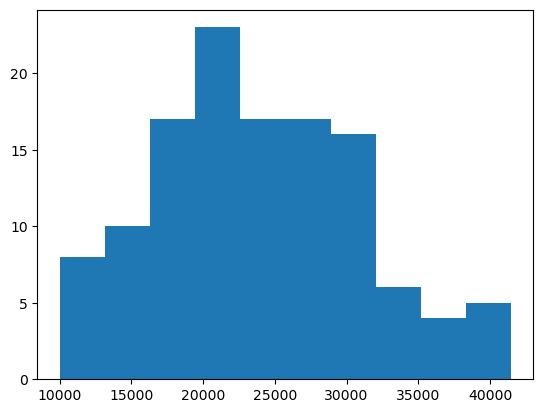

In [47]:
plt.hist(dry_trips)
plt.show()

# Other Exploratory Data Analysis